In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install opencv-python

In [ ]:
!pip install categorical

  Created wheel for categorical: filename=categorical-0.1.4-py3-none-any.whl size=4552 sha256=63c5c6f3522aaaa40fdf8ee93c806733342ff85231486673bb236d7406f1cbdd
  Stored in directory: /root/.cache/pip/wheels/ea/0c/fd/9c5ade13a589a48840b29238ab565144bccd1eee7c276795d3
Successfully built categorical


In [ ]:
!pip install patchify

In [ ]:
!pip install tensorflow

In [ ]:
!pip install segmentation-models

     |████████████████████████████████| 50 kB 6.3 MB/s 


In [ ]:
!pip install sklearn

In [ ]:
!pip3 install matplotlib

In [ ]:
import os
import cv2
import numpy as np
import random
from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
import segmentation_models as sm
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical

from tensorflow.keras.metrics import MeanIoU

Segmentation Models: using `keras` framework.


In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()

Now patchifying image: /content/drive/MyDrive/dataset/Tile 3/images/image_part_009.jpg
Now patchifying image: /content/drive/MyDrive/dataset/Tile 3/images/image_part_007.jpg
Now patchifying image: /content/drive/MyDrive/dataset/Tile 3/images/image_part_008.jpg
Now patchifying image: /content/drive/MyDrive/dataset/Tile 3/images/image_part_004.jpg
Now patchifying image: /content/drive/MyDrive/dataset/Tile 3/images/image_part_006.jpg
Now patchifying image: /content/drive/MyDrive/dataset/Tile 3/images/image_part_002.jpg
Now patchifying image: /content/drive/MyDrive/dataset/Tile 3/images/image_part_003.jpg
Now patchifying image: /content/drive/MyDrive/dataset/Tile 3/images/image_part_001.jpg
Now patchifying image: /content/drive/MyDrive/dataset/Tile 3/images/image_part_005.jpg
Now patchifying image: /content/drive/MyDrive/dataset/Tile 4/images/image_part_003.jpg
Now patchifying image: /content/drive/MyDrive/dataset/Tile 4/images/image_part_008.jpg
Now patchifying image: /content/drive/MyDri

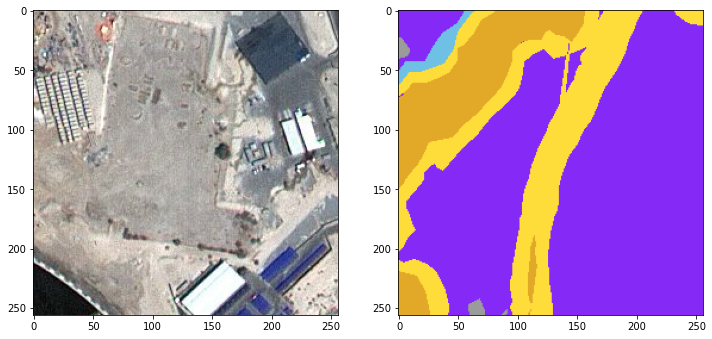

Unique labels in label dataset are:  [0 1 2 3 4 5]


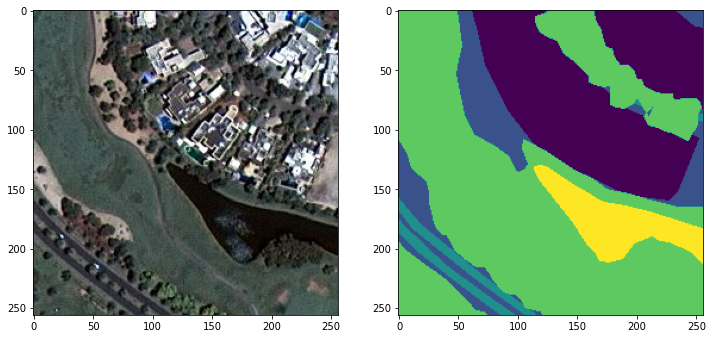

In [ ]:
root_directory = '/content/drive/MyDrive/dataset'

patch_size = 256
image_dataset = []  
for path, subdirs, files in os.walk(root_directory):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':   #Find all 'images' directories
        images = os.listdir(path)  #List of all image names in this subdirectory
        for i, image_name in enumerate(images):  
            if image_name.endswith(".jpg"):   #Only read jpg images...
               
                image = cv2.imread(path+"/"+image_name, 1)  #Read each image as BGR
                SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                image = Image.fromarray(image)
                image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                image = np.array(image)             
       
                #Extract patches from each image
                print("Now patchifying image:", path+"/"+image_name)
                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        
                        single_patch_img = patches_img[i,j,:,:]
                        
                        #Use minmaxscaler instead of just dividing by 255. 
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. 
                        single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.                               
                        image_dataset.append(single_patch_img)
mask_dataset = []  
for path, subdirs, files in os.walk(root_directory):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'masks':   #Find all 'images' directories
        masks = os.listdir(path)  #List of all image names in this subdirectory
        for i, mask_name in enumerate(masks):  
            if mask_name.endswith(".png"):   #Only read png images... (masks in this dataset)
               
                mask = cv2.imread(path+"/"+mask_name, 1)  #Read each image as Grey (or color but remember to map each color to an integer)
                mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                mask = Image.fromarray(mask)
                mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #mask = mask.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                mask = np.array(mask)             
       
                #Extract patches from each image
                print("Now patchifying mask:", path+"/"+mask_name)
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):
                        
                        single_patch_mask = patches_mask[i,j,:,:]
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. #No need to scale masks, but you can do it if you want
                        single_patch_mask = single_patch_mask[0] #Drop the extra unecessary dimension that patchify adds.                               
                        mask_dataset.append(single_patch_mask)                        
                        
                
                
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)             

image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.show()


Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

Road = '#6EC1E4'.lstrip('#') 
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

Vegetation =  'FEDD3A'.lstrip('#') 
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

Water = 'E2A929'.lstrip('#') 
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

Unlabeled = '#9B9B9B'.lstrip('#') 
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155

label = single_patch_mask


def rgb_to_2D_label(label):
    """
    Suply our labale masks as input in RGB format. 
    Replace pixels with specific RGB values ...
    """
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == Building,axis=-1)] = 0
    label_seg [np.all(label==Land,axis=-1)] = 1
    label_seg [np.all(label==Road,axis=-1)] = 2
    label_seg [np.all(label==Vegetation,axis=-1)] = 3
    label_seg [np.all(label==Water,axis=-1)] = 4
    label_seg [np.all(label==Unlabeled,axis=-1)] = 5
    
    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels
    
    return label_seg


labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)    

labels = np.array(labels)   
labels = np.expand_dims(labels, axis=3)
 

print("Unique labels in label dataset are: ", np.unique(labels))

G fc
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()
n_classes = len(np.unique(labels))

labels_cat = to_categorical(labels, num_classes=n_classes)

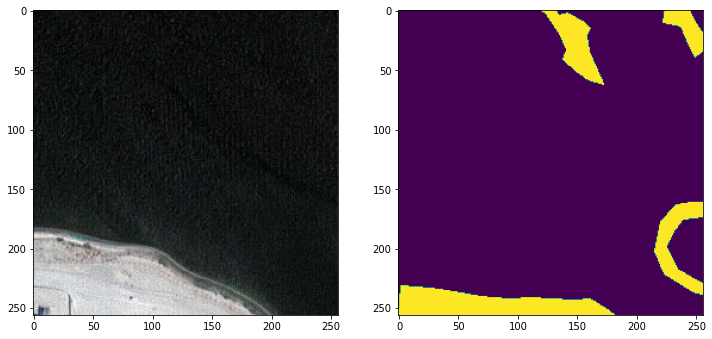

In [ ]:
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()
n_classes = len(np.unique(labels))

labels_cat = to_categorical(labels, num_classes=n_classes)

In [ ]:
 X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.30, random_state = 42)

In [ ]:
weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
dice_loss = sm.losses.DiceLoss(class_weights=weights) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)  #


IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

def multi_unet_model(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.2)(c1)  # Original 0.1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
  
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c1)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    return model
metrics=['accuracy', jacard_coef]

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
# loss='categorical_crossentropy'
#loss ='mse'
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 dropout (Dropout)           (None, 256, 256, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 16)      2320      
                                                                 
 conv2d_2 (Conv2D)           (None, 256, 256, 6)       102       
                                                                 
Total params: 2,870
Trainable params: 2,870
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history1 = model.fit(X_train, y_train, 
                    batch_size =16, 
                    verbose=1, 
                    epochs=800, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

Epoch 1/800
16/16 [==============================] - 13s 181ms/step - loss: 1.0209 - accuracy: 0.3667 - jacard_coef: 0.1252 - val_loss: 1.0194 - val_accuracy: 0.2922 - val_jacard_coef: 0.1303
Epoch 2/800
16/16 [==============================] - 2s 118ms/step - loss: 1.0156 - accuracy: 0.3657 - jacard_coef: 0.1437 - val_loss: 1.0171 - val_accuracy: 0.4121 - val_jacard_coef: 0.1427
Epoch 3/800
16/16 [==============================] - 2s 120ms/step - loss: 1.0133 - accuracy: 0.3719 - jacard_coef: 0.1513 - val_loss: 1.0140 - val_accuracy: 0.4426 - val_jacard_coef: 0.1473
Epoch 4/800
16/16 [==============================] - 2s 119ms/step - loss: 1.0114 - accuracy: 0.3740 - jacard_coef: 0.1527 - val_loss: 1.0120 - val_accuracy: 0.4456 - val_jacard_coef: 0.1493
Epoch 5/800
16/16 [==============================] - 2s 121ms/step - loss: 1.0101 - accuracy: 0.3756 - jacard_coef: 0.1552 - val_loss: 1.0108 - val_accuracy: 0.4383 - val_jacard_coef: 0.1521
Epoch 6/800
16/16 [=========================

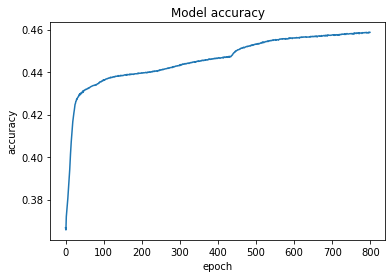

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history1.history['accuracy'])
plt.title('Model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [ ]:
model.save("model_final1.hdf5")

In [ ]:

from keras.models import load_model
model = load_model("/content/model_final1.hdf5",
custom_objects={'dice_loss_plus_1focal_loss': total_loss,
'jacard_coef':jacard_coef})


In [ ]:
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)


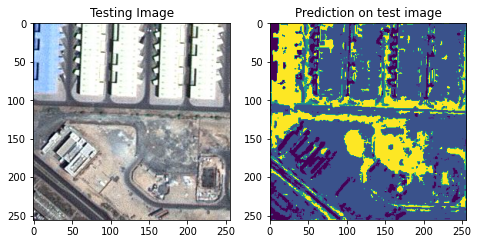

In [ ]:
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)

plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()